In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, r2_score, mean_absolute_error, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Лабораторная №4 - Проведение исследований с алгоритмом Случайный лес

## 1.Выбор начальных условий

In [6]:
pd.options.display.max_columns = None
data_classification = pd.read_csv('class_data/stackoverflow_full.csv').drop('Unnamed: 0', axis=1) #Выгрузка csv с данными классификации

files = ['FOOD-DATA-GROUP1.csv', 'FOOD-DATA-GROUP2.csv', 'FOOD-DATA-GROUP3.csv', 'FOOD-DATA-GROUP4.csv', 'FOOD-DATA-GROUP5.csv']
data_reg = pd.concat((pd.read_csv(f'reg_data/{f}') for f in files), ignore_index=True).drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1) #объединение и выгрузка сразу всех файлов с данными регрессии

Для оценки качества Классификации будем использовать такие же метрики как в прошлой работе: 
- Accuracy (Процент правильных предсказаний)
- F1-Score (важная метрика если классы несбалансированны)
- Confusion Matrix (Матрица которая покажет полную карту в работе модели)

Для оценки качества Регрессии будем использовать такие же базовые метрики как и в прошлой работе:

- RMSE (показывает типичный размер ошибки в исходных единицах) 
- MAE (устойчива к выбросам)
- R^2 (показывает общее качество модели)

## 2.Создание бейзлайна и оценка качества

Перед созданием и обучением модели, нам надо немного почистить и закодировать данные в датафрейме Классификации, тк модель не сможет работать с object признаками. Датафрейм регрессии уже готов для обучения модели.

In [12]:
def encoder_data(data: pd.DataFrame):
    onehot = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    Ordinal = OrdinalEncoder()
    
    if 'HaveWorkedWith' in data.columns:
        tech_dummies = data['HaveWorkedWith'].str.get_dummies(sep=';')
        data = pd.concat([data, tech_dummies], axis=1)
        data = data.drop('HaveWorkedWith', axis=1)
    
    categorical_features = data.select_dtypes(include=['object']).columns
    for col in categorical_features:
        
        if data[col].nunique() == 2:
            col_encoded = onehot.fit_transform(data[[col]])
            col_df = pd.DataFrame(col_encoded, columns=onehot.get_feature_names_out([col]))
            data = pd.concat([data.drop(col, axis=1), col_df], axis=1)
            
        else:
            col_encoded = Ordinal.fit_transform(data[[col]])
            col_df = pd.DataFrame(col_encoded, columns=Ordinal.get_feature_names_out([col]))
            data = pd.concat([data.drop(col, axis=1), col_df], axis=1)
    return data

data_classification_encoded = encoder_data(data_classification)

После всей кодировки данных перейдём к обучению моделей. Разделим данные на тренировочные и тестовые для обучения и проверки метрик на данных которые модель ещё не видела и приступим к обучению

In [14]:
y_classification = data_classification_encoded['Employed']
x_classification = data_classification_encoded.drop('Employed', axis = 1)

y_reg = data_reg['Nutrition Density']
x_reg = data_reg.drop(['Nutrition Density','food'], axis=1)

X_train_classification, X_test_classification, y_train_classification, y_test_classification = train_test_split(x_classification, y_classification, test_size=0.33, 
                                                                                                                random_state=42) # разделение данных на тестовые и обучающие выборки

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(x_reg, y_reg, test_size=0.33, random_state=42)

Далее Создадим модели Случайного леса и обучим их

In [16]:
classification_model = RandomForestClassifier() #модель Случайного леса для классификации
Reg_model = RandomForestRegressor() #Модель Случайного леса для регрессии

classification_model_fit = classification_model.fit(X_train_classification, y_train_classification) # обучение модели Классификации
Reg_model_fit = Reg_model.fit(X_train_reg, y_train_reg) # Обучение модели Регрессии

classification_predict = classification_model_fit.predict(X_test_classification) # Предсказываем для дальнейшего просмотра метрик
reg_predict = Reg_model_fit.predict(X_test_reg)

Метрики Случайного леса для классификации: 
Accuracy - 0.9745493544528318 
f1 - 0.976319324505853



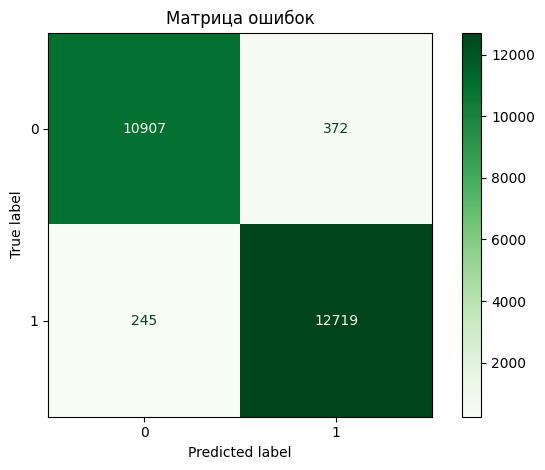

Метрики Случайного леса регрессии: 
MAE - 10.948383312262957 
R^2 - 0.943657180783497
RMSE - 36.381887790395375



In [17]:
def metrics_class(true, predict):
    print(f'Метрики Случайного леса для классификации: \n'
          f'Accuracy - {accuracy_score(true, predict)} \n'
          f'f1 - {f1_score(true, predict)}\n')

    matrix = confusion_matrix(true, predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
    disp.plot(cmap='Greens', values_format='d')
    plt.title('Матрица ошибок')
    plt.tight_layout()
    plt.show()

metrics_class(y_test_classification, classification_predict)

def metric_reg(true, predict):
        print(f'Метрики Случайного леса регрессии: \n'
          f'MAE - {mean_absolute_error(true, predict)} \n'
          f'R^2 - {r2_score(true, predict)}\n'
          f'RMSE - {np.sqrt(mean_squared_error(true, predict))}\n')
metric_reg(y_test_reg, reg_predict)

##### Метрики для бинарной классификации оказались следующими:
- Accuracy - 0.974 Очень высокий результат и в нём нет ничего подозрительного, прекрасные и вполне ожидаемые результаты для Ансамбля - Случайный лес
- f1 - 0.976 Так же превосходный показатель, их схожесть говорит, что о том, что в данных нету дисбаланса, что мы уже давно проверили
- Матрица ошибок показывает хорошую картину, всего 219 ошибок в 1 и 399 в 0
##### Метрики для регрессии оказались следующими:
- MAE - 10.9 означает, что средняя ошибка составляет 10.9 единицы, это превосходный результат
- R² - 0.94 модель объясняет 94% дисперсии целевой переменной. Тоже идеальный результат
- RMSE - 37.1 стандартное отклонение ошибок 37 единицы.

## 3.Улучшение бейзлайна

##### Модели себя показали просто прекрасно и на базовом бейзлайне, ощущение, что идти дальше некуда. Но Случайный лес практически невозможно переобучить нежели обычное Дерево решений, поэтому попытаемся сделать:
- Происк оптимальных гиперпараметров и Кросс-валидация
##### Что мы делать не будем, в отличи от других работ:
- Избавляться от мультиколлинерности в данных, Случайный лест устойчив к такому
- Не будем масштабировать данные, так это может быть даже вредно для Древоподобных моделей (Они работают с порядком, а не величинами).

### Найдём гиперпараметры модели с кросс-валидацией

##### Параметры для Случайного леса:
- n_estimators - Количество деревьев учавствующих в голосовании
- max_depth - Максимальная глубина
- min_samples_leaf - Минимальное samples в листе
- min_samples_split - Минимальное samples для разделения
- max_features - Количество признаков для поиска лучшего разделения

In [25]:
rf_class_params = {
    'n_estimators': [50, 100, 200],          
    'max_depth': [5, 10, 20],         
    'min_samples_split': [2, 5, 10],       
    'min_samples_leaf': [1, 2, 4],        
    'max_features': ['sqrt', 'log2']          
}

rf_reg_params = {
    'n_estimators': [50, 100, 200],       
    'max_depth': [5, 10, 20],        
    'min_samples_split': [2, 5, 10],      
    'min_samples_leaf': [1, 2, 4],        
    'max_features': ['sqrt', 'log2']  
}

model_class = RandomForestClassifier()
grid_class = GridSearchCV(estimator=model_class, param_grid=rf_class_params,cv=5) 

model_reg = RandomForestRegressor()
grid_reg = GridSearchCV(estimator=model_reg, param_grid=rf_reg_params, cv=5)

Tree_Class = grid_class.fit(X_train_classification, y_train_classification)
Tree_Reg = grid_reg.fit(X_train_reg, y_train_reg)

Метрики Случайного леса для классификации: 
Accuracy - 0.9734768799241018 
f1 - 0.975364928546799



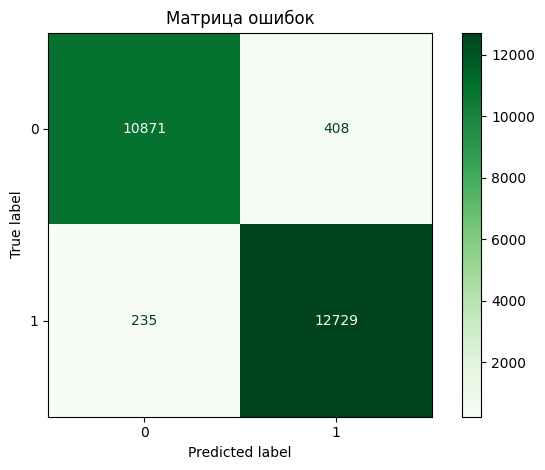

Метрики Случайного леса регрессии: 
MAE - 20.664867471397304 
R^2 - 0.9155942189495074
RMSE - 44.52993278574182



In [21]:
predict_class = Tree_Class.predict(X_test_classification)
predict_reg = Tree_Reg.predict(X_test_reg)

metrics_class(y_test_classification, predict_class)
metric_reg(y_test_reg, predict_reg)

Метрики Случайного леса классификации на новом бейзлайне:
- Accuracy - 0.973 результат показал себя на 0.002 хуже чем базовый бейзлайн, изменений считай что и нету
- f1 - 0.975 ситуация идентичная, что и с Accuracy
##### Можно сделать вывод, что базовые гиперпараметры при создании модели являются оптимальными для данной задачи

Метрики Случайного леса регрессии на новом бейзлайне:
- MAE - 20.6
- R^2 - 0.91
- RMSE - 44.52
##### В случае с регрессии метрики показали себя ещё хуже, чем было изначально, связано это скорее всего с тем, что max_features - Количество признаков для поиска лучшего разделения были выбраны sqrt или log2, что плохо сказалось на предсказании модели, но метрики так же неплохие

# 4.Имплементация алгоритма машинного обучения 

В данном задании мы будем создавать собственный Ансамбль случайного леса и проверять его на обоих бейзлайнах. Нам надо сделать
- Базовое дерево решений которое будет использоваться в Ансамбле
- Сам Ансабль Случайный лес
- Подбор Гиперпараметров к нему

In [28]:
class DecisionTree:
    def __init__(self, max_depth=5, min_samples_split=2, mode="classification"):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.mode = mode
        self.tree = None

    class Node:
        def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
            self.feature = feature
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value  # значение в листе

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        self.tree = self._build_tree(X, y, depth=0)

    def _build_tree(self, X, y, depth):
        n_samples, n_features = X.shape

        # условия остановки
        if (
            depth >= self.max_depth
            or n_samples < self.min_samples_split
            or len(np.unique(y)) == 1
        ):
            return self.Node(value=self._leaf_value(y))

        best_feat, best_thresh, best_impurity = None, None, np.inf

        # перебираем признаки
        for feat in range(n_features):
            values = np.unique(X[:, feat])
            if len(values) <= 1:
                continue

            # пороги — середины между соседними значениями
            thresholds = (values[:-1] + values[1:]) / 2

            # перебираем пороги
            for t in thresholds:
                left_mask = X[:, feat] <= t
                right_mask = ~left_mask

                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue

                y_left, y_right = y[left_mask], y[right_mask]
                impurity = self._impurity(y_left, y_right)

                if impurity < best_impurity:
                    best_feat, best_thresh, best_impurity = feat, t, impurity

        # если разбиение не найдено
        if best_feat is None:
            return self.Node(value=self._leaf_value(y))

        # строим поддеревья
        left_mask = X[:, best_feat] <= best_thresh
        right_mask = ~left_mask

        left_node = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_node = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return self.Node(best_feat, best_thresh, left_node, right_node)

    # impurity для классификации/регрессии
    def _impurity(self, y_left, y_right):
        n = len(y_left) + len(y_right)
        if self.mode == "classification":
            return (len(y_left) * self._gini(y_left) + len(y_right) * self._gini(y_right)) / n
        else:
            return (len(y_left) * self._variance(y_left) + len(y_right) * self._variance(y_right)) / n

    @staticmethod
    def _gini(y):
        counts = np.bincount(y.astype(int))
        p = counts / counts.sum()
        return 1 - np.sum(p ** 2)

    @staticmethod
    def _variance(y):
        return np.var(y) if len(y) > 0 else 0.0

    def _leaf_value(self, y):
        if len(y) == 0:
            # безопасный fallback, НЕ создаёт bias
            return 0 if self.mode == "classification" else 0.0

        if self.mode == "classification":
            return Counter(y).most_common(1)[0][0]
        else:
            return float(np.mean(y))

    # предсказание
    def predict(self, X):
        X = np.asarray(X, dtype=float)
        return np.array([self._predict_one(x, self.tree) for x in X])

    def _predict_one(self, x, node):
        if node.value is not None:
            return node.value

        if x[node.feature] <= node.threshold:
            return self._predict_one(x, node.left)
        else:
            return self._predict_one(x, node.right)

Класс Дерева решений возьмём с прошлой лабораторной работы

In [30]:
from copy import deepcopy
from collections import Counter
from itertools import product

class RandomForest:
    def __init__(self, n_estimators=10, max_depth=5, min_samples_split=2, max_features=None, mode="classification"):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.mode = mode
        self.trees = []
        self.features_idx = []

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y)
        n_samples, n_features = X.shape

        if self.max_features is None:
            self.max_features = n_features

        self.trees = []
        self.features_idx = []

        for _ in range(self.n_estimators):
            # bootstrap sampling
            idx = np.random.choice(n_samples, n_samples, replace=True)
            X_sample = X[idx]
            y_sample = y[idx]

            # случайный поднабор признаков
            feat_idx = np.random.choice(n_features, self.max_features, replace=False)
            self.features_idx.append(feat_idx)
            X_sample_sub = X_sample[:, feat_idx]

            tree = DecisionTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split, mode=self.mode)
            tree.fit(X_sample_sub, y_sample)
            self.trees.append(tree)

    def predict(self, X):
        X = np.asarray(X, dtype=float)
        predictions = []

        for tree, feat_idx in zip(self.trees, self.features_idx):
            preds = tree.predict(X[:, feat_idx])
            predictions.append(preds)

        predictions = np.array(predictions)  # shape: n_estimators x n_samples

        if self.mode == "classification":
            # majority vote
            final_preds = []
            for col in predictions.T:
                final_preds.append(np.bincount(col.astype(int)).argmax())
            return np.array(final_preds)
        else:
            # среднее для регрессии
            return np.mean(predictions, axis=0)

После написания основного ансамбля обучим нашу кастомную модель и проверим её метрики

In [25]:
model_class = RandomForest(mode="classification")
model_reg = RandomForest(mode="Regression")

model_class.fit(X_train_classification, y_train_classification)
model_reg.fit(X_train_reg, y_train_reg)

Метрики Случайного леса для классификации: 
Accuracy - 0.8685806212102463 
f1 - 0.878313345046215



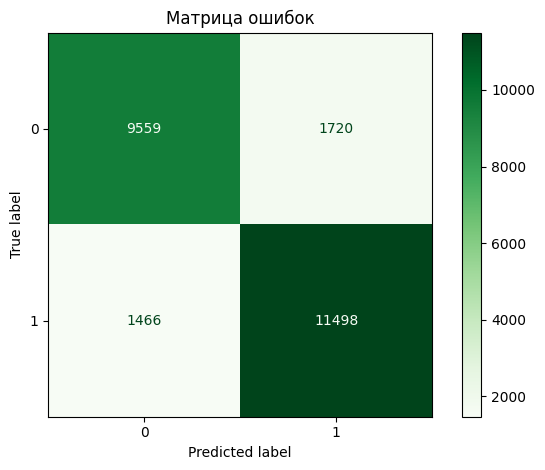

Метрики Случайного леса регрессии: 
MAE - 25.769745478635254 
R^2 - 0.7736117156155693
RMSE - 72.92776722019107



In [26]:
pred_class = model_class.predict(X_test_classification)
pred_reg = model_reg.predict(X_test_reg)

metrics_class(y_test_classification, pred_class)
metric_reg(y_test_reg, pred_reg)

Метрики Самодельного Случайного леса классификации на новом бейзлайне:
- Accuracy - 0.868 
- f1 - 0.878 
##### Метрики классификации в данном случае показали себя хуже всех

Метрики Самодельного Случайного леса Регрессии на новом бейзлайне:
- MAE - 25.76
- R^2 - 0.77
- RMSE - 72.92
##### Метрики Регрессии так же показали себя хуже всех. Посмотрим сможем ли мы улучшить их как то на новом бейзлайне при подборе гиперпараметров с приминением CV

Посмотрим лучшие гиперпараметры моделей для наших данных и применим их к нашим новым моделям

In [33]:
print(f'Лучшие параметры для задачи регрессии:{grid_class.best_params_}')
print(f'Лучшие параметры для задачи Классификации:{grid_reg.best_params_}')

Лучшие параметры для задачи регрессии:{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Лучшие параметры для задачи Классификации:{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


Метрики Случайного леса для классификации: 
Accuracy - 0.9987212803695912 
f1 - 0.9988048883919967



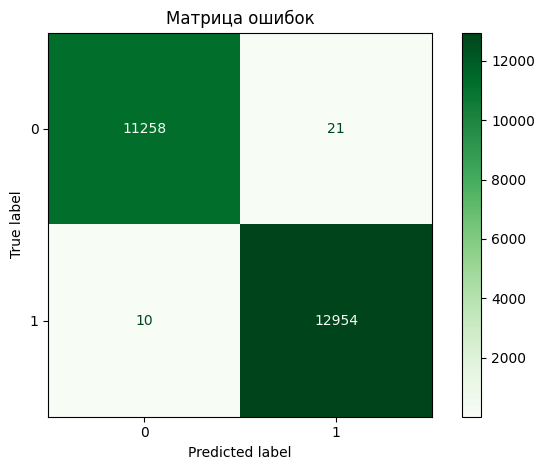

Метрики Случайного леса регрессии: 
MAE - 10.97889848202182 
R^2 - 0.9465407523612656
RMSE - 35.43866589531184



In [53]:
reg_model = RandomForest(n_estimators=grid_reg.best_params_['n_estimators'],
                          max_depth=grid_reg.best_params_['max_depth'],
                          min_samples_split=grid_reg.best_params_['min_samples_split'],
                          mode="regression")

reg_model.fit(X_train_reg, y_train_reg)

class_model = RandomForest(n_estimators=grid_class.best_params_['n_estimators'],
                          max_depth=grid_class.best_params_['max_depth'],
                          min_samples_split=grid_class.best_params_['min_samples_split'],
                          mode="classification")

class_model.fit(X_train_classification, y_train_classification)

metrics_class(y_test_classification, class_model.predict(X_test_classification))
metric_reg(y_test_reg, reg_model.predict(X_test_reg))

Метрики для нашего самодельного Случайного леса классификация в новом бейзлайне:
- Accuracy - 0.998
- f1 - 0.998
##### Метрики сильно выросли в сравнении с прошлым бейзлайном, смогли обогнать модель из sklearn, пока что это лучший результат среди моделей. Переобучение тут вряд ли есть, тк случайный лес очень устойчив к такому

Метрики для нашего самодельного Случайного леса для регрессии в новом бейзлайне:
- MAE - 10.97 
- R^2 - 0.946
- RMSE - 35.43
##### Ситуация идентичная с задачей Классификации, метрики показывают хороший результат

# Вывод по проделанной работе

В ходе лабораторной работы мы научились работать и изучили такую модель ансамбля как Случайный лес. Случайный лес работает по принципу голосования, где мы заводим множество маленьких моделей Дерева решений и они голосуют за то, что мы поставим в целевой, благодаря такому принципу работу данная модель очень устойчива к переобучению. В данной работе мы сначала взяли модель из sklearn и обучили её на нашем базовом бейзлайне, далее составили новый бейзлайн. В нём было решено лишь подобрать гиперпараметры и cv, тк древоподобной модели совсем не обязательно масштабировать данные и удалять мультиколлинерность. Далее мы написали собственный класс Случайного леса и проверили на нём обе бейзлана, лучше всех справилась наша модель на новом безлайне.